In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm
import IPython.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch


pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(777)

In [5]:
DATA_DIR = Path("/home/knikaido/work/BirdCLEF2021/data/")
MAIN_DATA_DIR = DATA_DIR / 'birdclef-2021'
OUTPUT_DIR = MAIN_DATA_DIR / 'birdclef-2021-melspectrogram'

In [6]:
######################
# Data #
######################
train_datadir = MAIN_DATA_DIR / 'train_short_audio'
train_csv = MAIN_DATA_DIR / 'train_metadata.csv'
train_soundscape = MAIN_DATA_DIR / 'train_soundscape_labels.csv'

output_train_datadir = OUTPUT_DIR / 'train_short_audio'

In [7]:
train = pd.read_csv(MAIN_DATA_DIR / 'train_metadata.csv')
train

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


In [8]:
idx = 0

In [12]:
raw = train.iloc[idx]
wav_name = raw["filename"]
ebird_code = raw["primary_label"]
y, sr = sf.read(train_datadir / ebird_code / wav_name)

In [13]:
IPython.display.Audio(train_datadir / ebird_code / wav_name)

## librosa

(128, 3980)
CPU times: user 283 ms, sys: 819 ms, total: 1.1 s
Wall time: 154 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


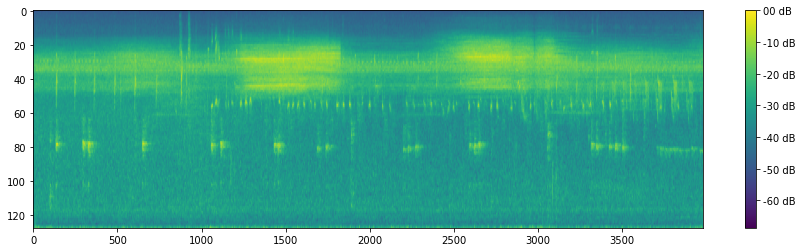

In [48]:
%%time

melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128,
            fmin=40, fmax=16000)
melspec = librosa.power_to_db(np.abs(melspec), ref=np.max).astype(np.float32)

print(melspec.shape)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(melspec))
plt.axes().set_aspect('auto')
plt.colorbar(format='%02.0f dB')   

## torchlibrosa

In [21]:
from torchlibrosa import Spectrogram, LogmelFilterBank
        # Spectrogram extractor
spectrogram_extractor = Spectrogram(n_fft=2048, hop_length=512, 
    win_length=2048, window='hann', center=True, pad_mode='reflect', 
    freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sr, n_fft=2048, 
    n_mels=128, fmin=40, fmax=16000, ref=1.0, amin=1e-10, top_db=None, 
    freeze_parameters=True)

(3980, 128)
CPU times: user 730 ms, sys: 27.7 ms, total: 758 ms
Wall time: 134 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


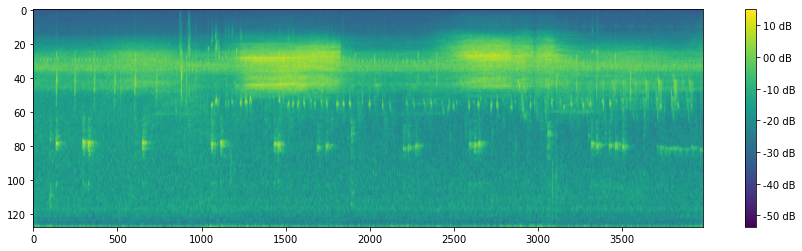

In [47]:
%%time

torch_y = torch.from_numpy(y.astype(np.float32)).clone().reshape(1, -1)
spectro = spectrogram_extractor(torch_y)
mel_torch = logmel_extractor(spectro)
mel_from_torch = mel_torch[0].to('cpu').detach().numpy().copy()
mel_from_torch = mel_from_torch.reshape(mel_from_torch.shape[1], mel_from_torch.shape[2])

print(mel_from_torch.shape)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_from_torch.T))
plt.axes().set_aspect('auto')
plt.colorbar(format='%02.0f dB')   

## torchaudio

(128, 3980)
CPU times: user 307 ms, sys: 2.37 ms, total: 310 ms
Wall time: 103 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


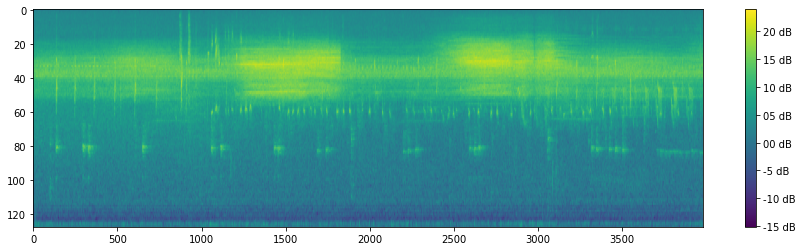

In [49]:
%%time

import torchaudio

y_audio, sample_rate = torchaudio.load(train_datadir / ebird_code / wav_name)
mel_torchaudio = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=2048, win_length=2048, hop_length=512,
                                               f_min=20, f_max=16000, n_mels=128, power=1.0)(y_audio)
mel_torchaudio = torchaudio.transforms.AmplitudeToDB()(mel_torchaudio)
mel_torchaudio = mel_torchaudio[0].to('cpu').detach().numpy().copy()

print(mel_torchaudio.shape)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_torchaudio))
plt.axes().set_aspect('auto')
plt.colorbar(format='%02.0f dB') 

top_dbによりそう